# Text Classification with Deep Learning

In this notebook you will see how to perform sentimental analysis, which is an application of text classification, using Deep learning and word embeddings. Our task will be to detect which reviews are positive  as opposed to a negative review.   
At the end of this notebook you should be able to:   
- Gather, prepare and inspect data
- Build simple models to start, and transition to deep learning if necessary
- Interpret and understand your models, to make sure you are actually capturing information and not noise

For this exercise you can download the IMDB sentiment dataset from [kaggle](https://www.kaggle.com/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

## Step 1: Clean your data

In [1]:
import pandas as pd
import numpy as np
import re

from sklearn.decomposition import PCA, TruncatedSVD

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

In [2]:
path = '/Users/ndah/NEC/aims_nlp/'
data = pd.read_csv(path + "IMDB_Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [3]:
# randomly select a subset
data = data.sample(n = 1000)

In [4]:
# drop any row without review or sentiment
data.dropna(axis=0, subset=('review', 'sentiment'), inplace=True)

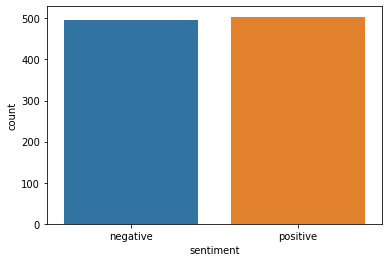

In [5]:
ax = sns.countplot(x="sentiment", data=data)

We have a balanced dataset with similar number of positive and negative reviews 

Before we start cleaning the data we first check the possible non alphanumeric characters in the text. This will give an idea of what we need to take into account when cleaning the data.  
to do this we use python's regular expression to identify all words that contain non alphanumeric characters. 
- If the dataset is too large we can take a random subset for this exercise

In [6]:
def find_non_apl_words(text):
    tokens = text.strip().split()
    return [t for t in tokens if not re.match(r'[^\W\d]*$', 
                                              t.translate(str.maketrans('', '', r'\.\"\,\?\!\@\'()'))
                                             )]

In [7]:
non_apha_num = []
non_apha_num = data['review'].apply(lambda x: find_non_apl_words(x))

In [8]:
non_apha_num

18292                                          [-chilling]
42404    [exception.<br, /><br, />I, off.<br, /><br, />...
27423    [99p., sh*t,, p*ss, -, -, -, lame-o, £8.00, -,...
34671    [Salvage:, 4, 10., close.<br, /><br, />Claire,...
44488    [that...<br, /><br, />This, 80s, -, government...
                               ...                        
33422                                    [so-so.the, 3/10]
12558                 [docu-drama, -, -, mid-air, -, -, -]
4558     [1995., on-screen, 95, more!<br, /><br, />Over...
1351     [60s, watching.<br, /><br, />Dr., up-and-up, d...
28414                                                   []
Name: review, Length: 1000, dtype: object

In [ ]:
def preprocessing(text):
    """ Include code to preprocess or clean the text"""

    clean_text = None
    return clean_text

### Expand contraction

In [ ]:
!pip install contractions

In [9]:
from helper.contractions import CONTRACTION_MAP
import contractions
# i've => i have

In [10]:
def expand_contractions(text):
    words = text.strip().split()
    words_expand = []
    for word in words:
        words_expand = contractions.fix(word)
        # if word in CONTRACTION_MAP.keys():
        #     words_expand.append(CONTRACTION_MAP[word])
        # else:
        #     words_expand.append(word)
            
    text_expand = ' '.join(words_expand)
    return text_expand

In [11]:
data['review_exp'] = data['review'].apply(lambda x: expand_contractions(x)) 

In [12]:
data.tail()

,review,sentiment,review_exp
33422,"normally,i would say i loved this movie.not fo...",negative,"normally,i would say i loved this movie.not fo..."
12558,"This may have been based on historical events,...",negative,"This may have been based on historical events,..."
4558,This video guide was the masterpiece of the ye...,negative,This video guide was the masterpiece of the ye...
1351,I've been playing this movie incessantly this ...,positive,I have been playing this movie incessantly thi...
28414,That shall be a documentary? I saw it (which i...,negative,That shall be a documentary? I saw it (which i...


### Tokenization

In [1]:
import nltk
import codecs

import string
import spacy
from bs4 import BeautifulSoup
from nltk.corpus import stopwords

In [14]:
nlp = spacy.load('en_core_web_sm')
print('spaCy Version: %s' % (spacy.__version__))

spaCy Version: 3.0.6


In [2]:
def strip_html_tags(text):
    soup = BeautifulSoup(text, "html.parser")
    stripped_text = soup.get_text()
    
    return stripped_text

# remove URL from text
def remove_url(text):
    """Remove URLs from a sample string"""
    return re.sub(r"http\S+", "", text)


def clean_text(text):
    
    text = remove_url(text)
    text = strip_html_tags(text)
    
    text = text.replace(r"http", "")
    text = text.replace(r"@\S+", "")
    text = text.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    text = text.replace(r"@", "at")
    
    return text


In [5]:
text = "exception.<br, /><br, />I, off.<br, />"
strip_html_tags(text)

'exception.I, off.'

In [16]:
# New stop words list 
customize_stop_words = [
    'film', 'movie'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

In [17]:
def tokenization_lemma(text):
    """ Tokenize and keep online clean tokens"""
    
    # clean text
    text = clean_text(text)
    
    text_nlp = nlp(text) # create spacy model
    
    token_list = []
    for token in text_nlp:
        if token.lemma_ != '-PRON-': # drop all pronouns
            t = re.sub(r"-$", "", token.lemma_) 
            t = re.sub(r"^-", "", t) 
            if len(t) > 1 and not(t in stopwords.words('english')):
                token_list.append(t)
        
    return token_list

In [18]:
data['review_clean'] = data['review_exp'].apply(lambda x: tokenization_lemma(x)) 

In [19]:
data.head()

,review,sentiment,review_exp,review_clean
18292,This is a disgrace to the name of all of the l...,negative,This is a disgrace to the name of all of the l...,"[disgrace, name, lovable, laughable, Critters,..."
42404,"Ok, I'm normally pretty open minded about movi...",negative,"Ok, I am normally pretty open minded about mov...","[ok, normally, pretty, open, minded, movie, no..."
27423,I bought this from Blockbuster for 99p. The gu...,negative,I bought this from Blockbuster for 99p. The gu...,"[buy, Blockbuster, 99p, guy, behind, counter, ..."
34671,Salvage: 4 out of 10. Groundhog Day meets a Ch...,negative,Salvage: 4 out of 10. Groundhog Day meets a Ch...,"[salvage, 10, Groundhog, Day, meet, Christian,..."
44488,"""Closet Land"" was sponsored by Amnesty Interna...",positive,"""Closet Land"" was sponsored by Amnesty Interna...","[Closet, Land, sponsor, Amnesty, International..."


In [20]:
data['class'] = data['sentiment'].apply(lambda x: 1 if x == 'positive' else 0) 

## EDA

In [21]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [22]:
# iterate through the csv file
def plot_wordcloud(reviews, title):
    """ Generate wordcloud"""
    
    stopwords = set(STOPWORDS)
    comment_words = ""
    for tokens in reviews:
        comment_words += " ".join(tokens)+" "
        
    wordcloud = WordCloud(
        width = 600, 
        height = 600,
        background_color ='white',
        stopwords = stopwords,
        min_font_size = 10
    ).generate(comment_words)

    # plot the WordCloud image                       
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.title(title, fontsize=20)
    plt.show()

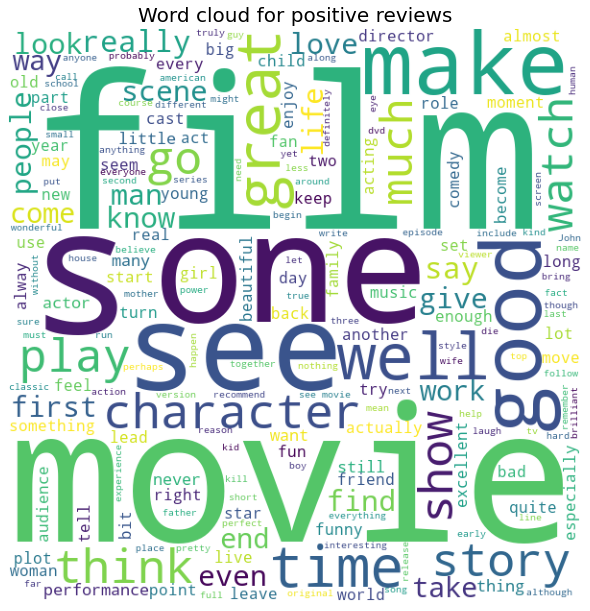

In [23]:
# WORD cloud positive reviews
title = "Word cloud for positive reviews"
positives = data[data.sentiment == 'positive']['review_clean']
plot_wordcloud(positives, title)

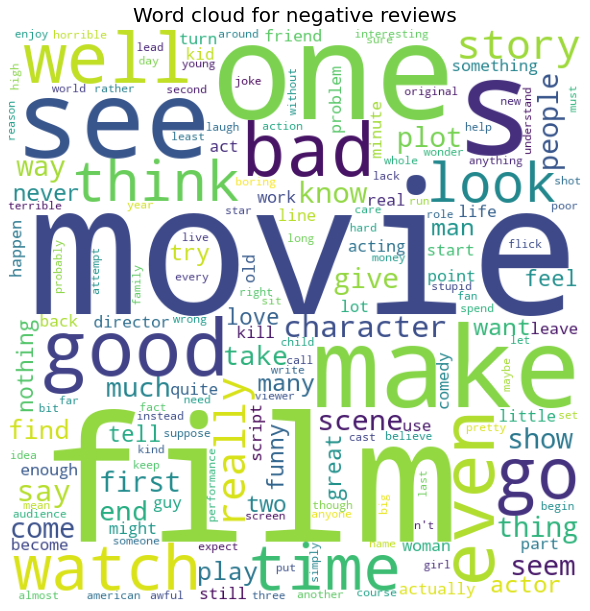

In [24]:
# WORD cloud negative reviews
title = "Word cloud for negative reviews"
negatives = data[data.sentiment == 'negative']['review_clean']
plot_wordcloud(negatives, title)

In [25]:
# New stop words list 
customize_stop_words = [
    'doi', 'preprint', 'copyright', 'org', 'https', 'et', 'al', 'author', 'figure', 'table', 'e-mail', 'file'
    'rights', 'reserved', 'permission', 'use', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 'al.', 'Elsevier', 'PMC', 'CZI',
    '-PRON-', 'usually'
]

# Mark them as stop words
for w in customize_stop_words:
    nlp.vocab[w].is_stop = True

### Training

In [26]:
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, LSTM, Dropout, Dense, Flatten, Input, Embedding, Conv1D, Input
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer

from tensorflow.keras.utils import plot_model

In [27]:
epochs = 5

In [28]:
X = data['review_clean']
y = data['class']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Shape of training data: {0},\nShape of test data: {1}".format(X_train.shape, X_test.shape))

Shape of training data: (800,),
Shape of test data: (200,)


The next step is to convert text integers.

In [30]:
# tokenize and keep the most frequent 5000 words
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

Different sentences can have different lengths. Neural networks in Keras expect input sentences to be of the same length. What we can do here is find the length of the longest sentence and then add zeros to the right of the sentences that are shorter than the longest sentence. This process is called padding.

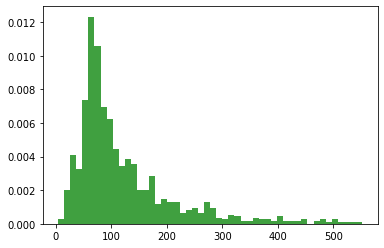

In [34]:
review_lens = X.apply(lambda x: len(x))
n, bins, patches = plt.hist(review_lens, 50, density=True, facecolor='g', alpha=0.75)

In [35]:
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size", vocab_size)

maxlen = 200
X_train=pad_sequences(X_train, padding='post' ,maxlen=maxlen)
X_test=pad_sequences(X_test, padding='post' ,maxlen=maxlen)

vocabulary size 13808


Next, we have to convert numbers into word embeddings. For word embeddings, you have two options. Either you can train your own word embeddings, or you can use pretrained word embeddings. In pretrained word embeddings, for each word, you have a pretrained vector representation. Glove and Stanford are the two most commonly used pretrained word embeddings. We will be using the Glove word embeddings in this chapter.

In [36]:
glove_file = '/Users/ndah/NEC/aims_nlp/glove.6B/glove.6B.100d.txt'
glove_embeddings=open(glove_file, encoding="utf8")

Next, we will create a dictionary where the keys will be the names of the words, and the values will be the corresponding word embedding vectors

In [37]:
embedd_dict=dict()

for embeddings in glove_embeddings:
    embedding_tokens = embeddings.split()
    emb_word = embedding_tokens[0]
    emb_vector = np.asarray(embedding_tokens[1:], dtype='float32')
    embedd_dict[emb_word] = emb_vector

glove_embeddings.close()

Finally, we will create a matrix where the row numbers of the matrix correspond to the index numbers for all the unique words in our dataset, and the columns contain the corresponding word embedding matrix from the Glove word embedding.

In [38]:
embedd_mat= np.zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embedd_dict.get(word)
    if embedding_vector is not None:
        embedd_mat[index] = embedding_vector
        

In [39]:
# The shape of the embedding matrix
embedd_mat.shape

(13808, 100)

Our embedding matrix contains xxxxx words, and one word is represented by a 100-dimensional vector.

We have created our embedding matrix that contains Glove word embeddings for the words in our corpus. Now, we can train our Neural Network Model in Keras. If you want to use word embeddings with your neural network model, you have to use Embedding() layer after the input layer and before any other layer in the neural network.  

- The first parameter to the embedding layer is your vocabulary size. 
- The second parameter is the number of dimensions of the output vector. Also, the embedding matrix is passed to the weights parameter. 
- Finally, you have to set the trainable attribute to False.  

The shape of the input layer will be the maximum sentence length. If you want to connect the output of the Embedding layer directly to a Dense layer, you have to flatten the result of the Embedding layer.  

The following script creates our LSTM network. The model contains two LSTM layers with 512 neurons, followed by three dense layers of 512, 256, and 2 neurons.  
The Softmax function is used in the final layer since this a binary classification problem.  

Finally, categorical cross entropy is used as a loss function, whereas the Adam optimizer is used to minimize the loss.

### Sentiment analysis with LSTM

In [40]:
# embedding layer
embedding_inputs = Input(shape=(maxlen))
embedding_layer = Embedding(vocab_size, 100, weights=[embedd_mat], trainable=False)(embedding_inputs)

# LSTM layers
lstm1 = LSTM(512, activation='relu', return_sequences=True)(embedding_layer)
lstm2 = LSTM(512, activation='relu', )(lstm1)
dense1 = Dense(512, activation='relu')(lstm2)
dense2 = Dense(256, activation='relu')(dense1)

output_layer = Dense(1, activation='softmax') (dense1)
model_lstm = Model(embedding_inputs, output_layer)
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

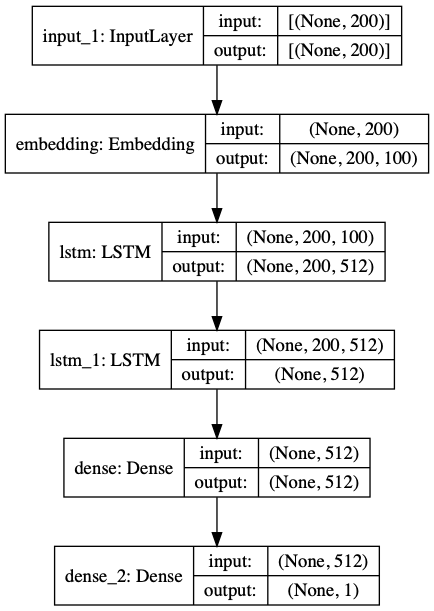

In [41]:
plot_model(model_lstm, to_file='model_plot1.png', show_shapes=True, show_layer_names=True)

In [42]:
history = model_lstm.fit(X_train, y_train, batch_size=64, epochs=epochs, verbose=1, validation_split=0.2)
score = model_lstm.evaluate(X_test, y_test, verbose=1)

Epoch 1/5
10/10 [==============================] - 42s 4s/step - loss: nan - accuracy: 0.5125 - val_loss: nan - val_accuracy: 0.5125
Epoch 2/5
10/10 [==============================] - 39s 4s/step - loss: nan - accuracy: 0.4875 - val_loss: nan - val_accuracy: 0.5125
Epoch 3/5
10/10 [==============================] - 39s 4s/step - loss: nan - accuracy: 0.4875 - val_loss: nan - val_accuracy: 0.5125
Epoch 4/5
10/10 [==============================] - 45s 5s/step - loss: nan - accuracy: 0.4875 - val_loss: nan - val_accuracy: 0.5125
Epoch 5/5
7/7 [==============================] - 6s 819ms/step - loss: nan - accuracy: 0.5100


In [43]:
print("Cross entropy loss", score[0])
print("Accuracy", score[1])

Cross entropy loss nan
Accuracy 0.5099999904632568


### Sentiment analysis with CNN

In [44]:
# embedding layer
embedding_inputs = Input(shape=(maxlen))
embedding_layer = Embedding(vocab_size, 100, weights=[embedd_mat], trainable=False)(embedding_inputs)

conv1 = Conv1D(128,3,strides=2,activation='relu') (embedding_layer)
conv2 = Conv1D(64,3,strides=2,activation='relu')(conv1)

flat1 = Flatten()(conv2)
drop1 = Dropout(0.2)(flat1)
dense1 = Dense(512,activation='relu')(drop1)
drop2 = Dropout(0.2)(dense1)

output_layer = Dense(1, activation='sigmoid')(drop2)

model_cnn = Model(embedding_inputs, output_layer)
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

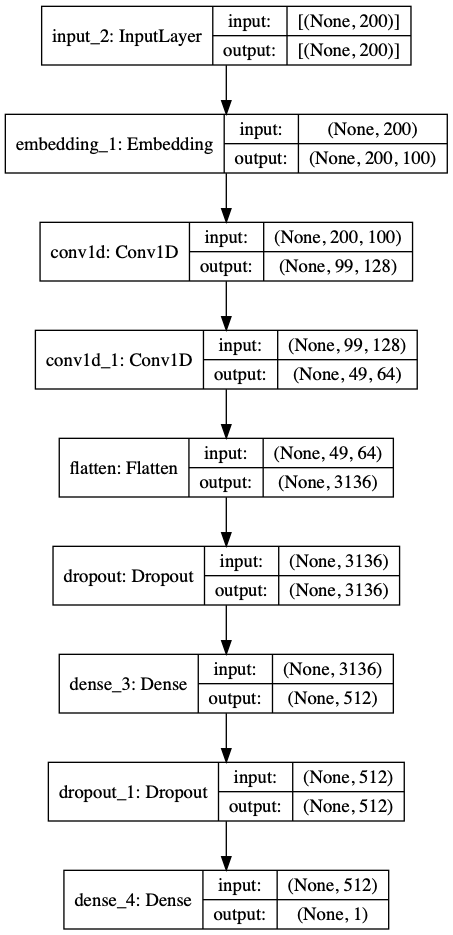

In [45]:
plot_model(model_cnn, to_file='model_plot_cnn.png', show_shapes=True, show_layer_names=True)

In [46]:
history = model_cnn.fit(X_train, y_train, batch_size=64, epochs=epochs, verbose=1, validation_split=0.2)
score = model_cnn.evaluate(X_test, y_test, verbose=1)

Epoch 1/5
10/10 [==============================] - 1s 67ms/step - loss: 0.0000e+00 - accuracy: 0.4922 - val_loss: 0.0000e+00 - val_accuracy: 0.5125
Epoch 2/5
10/10 [==============================] - 1s 57ms/step - loss: 0.0000e+00 - accuracy: 0.4875 - val_loss: 0.0000e+00 - val_accuracy: 0.5125
Epoch 3/5
10/10 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - accuracy: 0.4875 - val_loss: 0.0000e+00 - val_accuracy: 0.5125
Epoch 4/5
10/10 [==============================] - 0s 40ms/step - loss: 0.0000e+00 - accuracy: 0.4875 - val_loss: 0.0000e+00 - val_accuracy: 0.5125
Epoch 5/5
7/7 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 0.5100


In [47]:
print("Cross entropy loss", score[0])
print("Accuracy", score[1])

Cross entropy loss 0.0
Accuracy 0.5099999904632568


In [ ]:
# transformers for sentiment analysis